# Learning Curve and K Fold CV

The [King County Housing Data](https://www.kaggle.com/harlfoxem/housesalesprediction/data) from Kaggle will be used.  The model will predict house price.

To demonstrate why nested cv is helpful, a simple model will be created.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

### Previous Notebook
As per the *Demonstrate Internals of Cross Validation using a Pipeline* notebook:

In [2]:
# read king county housing data
all_data = pd.read_csv('./data/kc_house_data.csv')

# let's say the house was built, when it was last renovated
mask = all_data['yr_renovated'] != 0
all_data.loc[mask, 'yr_built'] = all_data.loc[mask, 'yr_renovated']

# remove the fields discussed above
all_data = all_data.drop(['id', 'date', 'zipcode', 'yr_renovated'], axis=1)

X_all = all_data.drop('price', axis=1)
y_all = all_data['price']

all_data.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1991,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,47.7379,-122.233,2720,8062


## Dask and Dask-ML
Dask is a wonderful tool which serves at least three purposes:
1. Allows for the analysis of data that is larger than the size of memory on one computer
2. Allows for efficient multi-processing on a single computer using all cores, or distributed processing on multiple computers
3. Creates additional processing efficiencies through caching

### Brief Dask Setup Instructions
Scikit Learn was designed to make parallel processing of certain operations so easy as to be almost transparent to the developer.  cross_val_score() is one such method.

With cross_val_score(), you can set n_jobs to -1 to use more of the cores on your multicore processor.  However in my timing tests, this was not as fast as using the Dask parallizing backend engine.

Scikit Learn has a hook which allows for the use of any parallizing backend engine, which includes Dask.  Setting this up is easy.  I recommend following the installation documentation for dask, dask-ml, and look at examples for dask-ml.  Here I will summarize the steps to show how easy it is.

My setup uses 2 desktop computers, each with 4 physical cores and hyperthreading.
1. conda install dask
2. conda install -c conda-forge dask-ml
3. at command line on one computer, start: dask-scheduler
4. at the command line on each computer whose CPUs you want to use, start: dask-worker <ip of scheduler>

```pre
import dask_ml.joblib
from sklearn.externals.joblib import parallel_backend
from dask.distributed import Client
client = Client('<ip of scheduler>:8786')
    
with parallel_backend('dask.distributed', scheduler_host='<ip of scheduler>:8786'):
    cross_val_score()
```

The above setup is even easier for a single computer.  See [Distributed Local](https://dask.pydata.org/en/latest/scheduling.html#dask-distributed-local).  Even when used for a single computer, this will make better use of your multi-core CPU.

Most ML algorithms use linear algebra which is computed via a BLAS library.  Anaconda comes with the MKL BLAS library which is optimized for Intel CPUs.  Generally one physical CPU cannot handle more than one BLAS operation at a time, so the use of hypterthreads does not help.  In fact in my timing tests it caused cross_val_score to run slower.  I found that setting the number of threads to be equal to the number of physical cores, produced the fasted times.  This is true in general when you are CPU bound on BLAS (Linear Algebra) operations.
```pre
dask-worker <ip of scheduler>:8786 --nprocs 1 --nthreads 4
```

### Effect of Data Size and K Fold
Here I will examine the relationship between CV score and the standard deviation of CV score with respect to data set size and K.

The full King County Housing dataset consists of 21613 records.  We can simulate having less observations, from the same distribution, by taking a random sample of these records.  In the following the size of the sample varies on a log scale from 20% to 100% of the total data.

A given random sample of data may be unrepresentative of the data as a whole.  To account for this, the random sample will be chosen 10 times for each dataset size.

#### More Data
For a given value of K, as data size goes up, both RMSE and standard deviation of RMSE will go down.

More data means more training data and more validation data.  More training data allows for a more accurate model to be built.  More validation data allows for a more stable estimate of the CV score.

#### Higher K
For a given data set size, as K goes up, the estimate of the RMSE will go down and the standard deviation of the estimate of the RMSE will go up.

It is very important to understand that CV is not used to create a model.  In most cases, the final model to be deployed will be built on all the available data.  The model to be deployed should not be one of the model built during cross validation.

will not be one of the models built during cross validation.

The purpose of CV is to provide an estimate of how well the model will do on out-of-sample data.  CV has nothing to do with making a specific model more accurate, rather CV tells you how accurate a model is.  If you are comparing two models, CV will tell you which is likely to be best. You can then choose to use the best model, but CV isn't affecting a specific model, rather it is affecting your choice of which model to use.



, rather CV tells you how accurate a model may be, an

CV has nothing to do with making a given model more accurate, rather CV is used to tell you how accurate a particular model may be, and given the choice between two models, or one model with different hyperparameters, CV can tell you which model is best and you can chose to use the best model.  But CV isn't affecting the model, rather it is affecting your choice of which model to use.


It will not be one of the models built during cross validation.

It is very important to understand that CV is not used to create a model.  The final model to be deployed will be built on all the available data (except in cases of very large dataset).  So CV has nothing to do with how to make a model more accurate.  CV tells you how accurate a model may be.  If you are comparing two models, or the hyperparameter settings for one model, CV will tell you what is likely to be best, and then you can chose to use what is best.  But this CV isn't affecting the model, rather it is affecting your choice of which model is best.



Higher K means there is more data to train on, so the pessimistic bias caused by training on less than the full dataset, is less.  With a smaller bias, the CV estimate of the model's accuracy will be less.

It is 


-- It is very important to understand that CV is not used to create a model, but to estimate the accuracy of a model.  A higher K will have a less pessimistic estimate of the model's accuracy, so the value will be lower, 


It is very important to understand that CV is *not* used to create a model.  Having a higher K, with a lower estimated RMSE, does not mean you have a more accurate model, it means you have a more accurate estimate of the model's performance.  And in particular, you have less pessimistic bias

It is very important to understand the accuracy of the model is not affected by computing a CV score to estimate that accuracy.  The model is not built fr

.  CV is used to estimate accuarcy, not create a model.

1. More data means more 

It is very important to understand that "RMSE will go down" does not mean the actual error of the model will go down, but rather the CV estimate of the error will go down.  Cross Validation is not used to create a model, but to determine how accurate a given model will be on out of sample data.

1. As data size goes up, both RMSE and standard deviation of RMSE, will go down for a given value of K.
2. As K goes up, the estimate of the RMSE will go down, but the standard deviation of the RMSE will go up, for a given data set size.

More data means more training data which allows for a more accurate model to be built and more validation data which allows for a more stable estimate of the CV score.

Higher K means more data to train on, so the pessimistic biased caused by training on less than the full dataset is reduced, but there is also less data to validate on, so the standard deviation of the CV score will go up.

* As K goes up, there is more data to train on, so the pessimistic bias (from training on less than the full data set) will be less.  That is, for a given data size, the CV estimate of the error will go down.  However with high K there is less data

It is very important to keep in mind that the purpose of Cross Validation is to provide an estimate of the model's performance on out-of-sample data.  With a more accurate estimate we can chose between two models choices ...

As the amount of data increases, the expectation is that the standard deviation of the RMSE cross validated scores decreases.  With more data, the model can better focus on the signal from the noise, and produce a more stable prediction.

Cross Validation provides an estimate of the model's performance.  It does not provide the model to be deployed to production. The model to be deployed to production should use all available data (unless there is so much data that this is unnecessary).

Cross validation provides a pessimistic estimate of the model's performance because it is built on less than the full amount of available data. ("Pessimistic" in this context means that the estimated performance is worse than the actual performance.)  Of course, if there is "data leakage", then cross validation provides a wildly optimistic estimate of performance.  But this is not the fault of cross validation, rather the fault is in the model building process.

Using 3 fold cross validation uses less data for model building (67%) than using 10 fold cross validation (90%).  As the number of folds goes up, the overly pessimistic bias goes down, and the estimate of model performance improves.

Using 3 fold cross validation uses more data for the validation (33%) than using 10 fold cross validation (10%). As the number of folds goes up, the variance of the performance estimates also goes up, having less data to validate the model on.

All of the above is graphically demonstrated below.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error

In [7]:
import dask_ml.joblib  # registers joblib plugin
# Scikit-learn bundles joblib, so you need to import from
# `sklearn.externals.joblib` instead of `joblib` directly
from sklearn.externals.joblib import parallel_backend

from dask.distributed import Client
client = Client('192.168.168.67:8786')
client

Client Scheduler: tcp://192.168.168.67:8786 Dashboard: http://192.168.168.67:8787/status,Cluster Workers: 2 Cores: 8 Memory: 67.45 GB


In [8]:
np.arange(0.2, 1.0, 0.1)
np.linspace(0.2, 1.0, 9)

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [15]:
from time import time
from numpy.random import choice

scale = StandardScaler()
pca = PCA(n_components=8)
knn = KNeighborsRegressor(n_neighbors=4)

pipe = Pipeline(steps=[('scale', scale),('pca',pca), ('knn',knn)])

# setup an explict crossvalidation generator for repeatability
k_folds = 10
random_seed=5
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

# set random seed for choice()
np.random.seed(9)
df = pd.DataFrame()
counter=0

start = time()
with parallel_backend('dask.distributed', scheduler_host='192.168.168.67:8786'):
    
    # 10 realizations of a subset of specific size to train and test on
    for i in range(10):
        
        # 10 different sizes to train and test on
        # a log scale from 0.2 to 1.0
        # for frac in np.logspace(np.log10(0.2), np.log10(1.0), 10):
        for frac in np.linspace(0.1, 1.0, 10):          

            # get a random sample of the data
            n = int(frac*len(X_all))
            idx = choice(len(X_all), size=n, replace=False)
            X = X_all.iloc[idx]
            y = y_all.values[idx] 

            # vary the number of folds
            for k_folds in [3, 5, 10, 20]:
                random_seed=5
                crossvalidation = KFold(n_splits=k_folds, random_state=random_seed+i)

                # compute the K cross validated scores
                scores = cross_val_score(pipe, X, y, cv=crossvalidation, 
                                     scoring='neg_mean_squared_error')

                # scikit learn returns these as negative mean squared error
                # more common is root-mean-squared-error
                rmse_values = np.sqrt(np.abs(scores))
                std_value = rmse_values.std()

                # use the mean of the cross validated scores
                rmse = rmse_values.mean()

                # accumulate the results
                df = df.append(pd.DataFrame(data=[[k_folds, n, rmse, std_value]], 
                                            columns=['k_fold', 'len', 'rmse', 'std']),
                               ignore_index=True)
                

print(f'Total Time: {time() - start}')

Total Time: 163.59113931655884


In [ ]:
client.close()

In [16]:
rmse_data = df.groupby(['k_fold', 'len'])['rmse'].mean()
rmse_data.head(11)

k_fold  len  
3       2161     198866.070544
        4322     190808.003398
        6483     183952.812765
        8645     184382.639785
        10806    179681.489250
        12967    173644.618854
        15129    171347.427777
        17290    171174.695622
        19451    171226.678871
        21613    168293.121593
5       2161     193965.541497
Name: rmse, dtype: float64

In [17]:
type(rmse_data)

pandas.core.series.Series

In [18]:
# applying the mean operator to the 2 field groupby creates
# a Pandas series with a 2 part index
# Data can be extracted via the outer index (K-fold)
rmse_data[3]

len
2161     198866.070544
4322     190808.003398
6483     183952.812765
8645     184382.639785
10806    179681.489250
12967    173644.618854
15129    171347.427777
17290    171174.695622
19451    171226.678871
21613    168293.121593
Name: rmse, dtype: float64

Text(0.5,1,'RMSE vs Records per K-Fold CV')

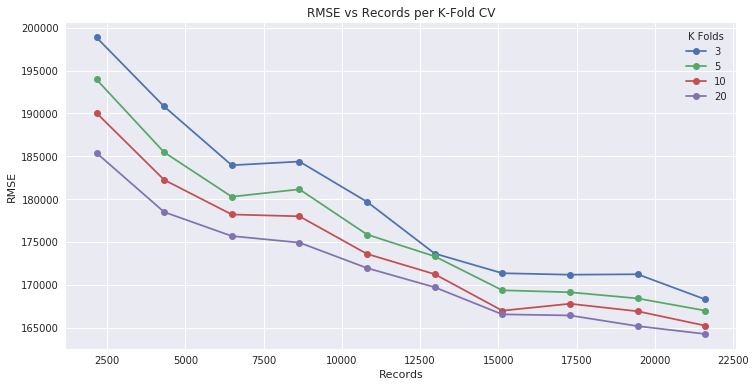

In [19]:
# plot RMSE vs Sample Size for various values of K
plt.figure(figsize=(12,6))
rmse_data = df.groupby(['k_fold','len'])['rmse'].mean()
for k in [3, 5, 10, 20]:
    plt.plot(rmse_data.loc[k].index.values, rmse_data.loc[k].values, marker='o', label=k)
plt.legend(title="K Folds")
plt.xlabel('Records')
plt.ylabel('RMSE')
plt.title('RMSE vs Records per K-Fold CV')

The general trend that more data lowers the RMSE is clear.

The general trend that more CV Folds results in a lower RMSE estimate is also clear.  This is because the amount of pessimisum in the bias is less, as there is more data available for training with more folds.

Note: this does not mean the model "built by k-fold cross validation" with a higher number of folds is better.  The model to be deployed is not one of the models built during cross validation.  Rather this means that the estimate of the model's performance has less bias when k is larger.

Text(0.5,1,'Standard Dev of RMSE vs Records per K-Fold CV')

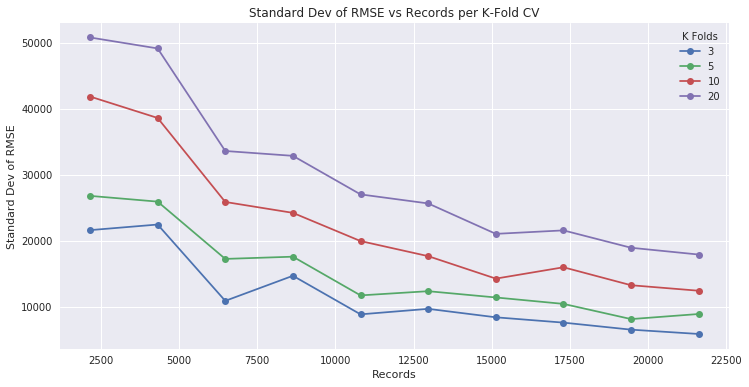

In [20]:
plt.figure(figsize=(12,6))
std_data = df.groupby(['k_fold','len'])['std'].mean()
for k in [3, 5, 10, 20]:
    plt.plot(std_data.loc[k].index.values, std_data.loc[k].values, marker='o', label=k)
plt.legend(title="K Folds")
plt.xlabel('Records')
plt.ylabel('Standard Dev of RMSE')
plt.title('Standard Dev of RMSE vs Records per K-Fold CV')

The general trend that more data lowers the standard deviation of the RMSE estimate is clear.

The general trend that more CV Folds results in more variance is also clear.  This is because there is less validation data available with the are more folds.

### Which Value of K is "Best"
The Bias-Variance tradeoff means that for a more accurate estimate of the model's performance, the higher the variance of that estimate.  As such, there is no "best" value.

For the above model, it might be argued that K=5 results in a good tradeoff of bias vs variance.